# Used Car Price Prediction Project

This application will predict the prices of used cars using a RandomForestRegressor.
   
The data set is downloaded from kaggle https://www.kaggle.com/ishaanthareja007/car-details
The data will be split into 3 sets: training.csv, validation.csv, and testing.csv sets
    
We will use RMSLE (root mean squared log error), MAPE (mean absolute percentage error), and R Squared error to determine the accuracy of the predicted prices

# Import data

In [491]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import math

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display, clear_output
from IPython.display import display

In [492]:
#!jupyter nbextension install --sys-prefix --symlink --overwrite --py voila-gridstack
#!jupyter serverextension enable voila --sys-prefix

In [493]:
# import training and validation data into a dataframe
df = pd.read_csv("car-data.csv")
df2 = df.copy()

# Explore data

This shows the structure of the CSV file that we are using.

The price is in Rupees as the used car company is headquartered in India
and the mileage is in Kilometers.

The unit types do not interfere with the machine learning algorithm as long as they are consistent

In [494]:
# Display the DataFrame
df.head()

,name,year,price,mileage,fuel,seller_type,transmission,owner,kmpl,engine,max_power,torque,seats
0,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
1,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0
2,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
3,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0
4,Hyundai Xcent 1.2 VTVT E Plus,2017,440000,45000,Petrol,Individual,Manual,First Owner,20.14 kmpl,1197 CC,81.86 bhp,113.75nm@ 4000rpm,5.0


Next, we examine more info about the size of the dataframe and its content

Here we can see the total entries, column types and the number of missing values

In [495]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8127 entries, 0 to 8126
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   name          8127 non-null   object 
 1   year          8127 non-null   int64  
 2   price         8127 non-null   int64  
 3   mileage       8127 non-null   int64  
 4   fuel          8127 non-null   object 
 5   seller_type   8127 non-null   object 
 6   transmission  8127 non-null   object 
 7   owner         8127 non-null   object 
 8   kmpl          7906 non-null   object 
 9   engine        7906 non-null   object 
 10  max_power     7912 non-null   object 
 11  torque        7905 non-null   object 
 12  seats         7906 non-null   float64
dtypes: float64(1), int64(3), object(9)
memory usage: 825.5+ KB


### Visualize relationships among data

It is not necessary to assess the correlation between price and all columns right now as the machine learning algorithm can assess the strengths of these relationships. However, we will explore some relationships here.

We create a scatter plot comparing mileage and price.This graph shows a strong correlation. 
(lower mileage cars sell for higher prices)

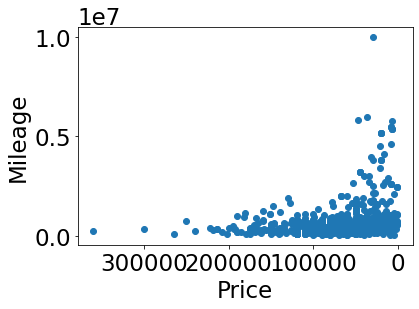

In [496]:
fig, ax = plt.subplots()
ax.invert_xaxis()
plt.xlabel("Price")
plt.ylabel("Mileage")
ax.scatter(df["mileage"][:1000], df["price"][:1000])

We create a scatter plot comparing year vs price. This graph also shows a relationship. (newer models sell for higher prices in general)

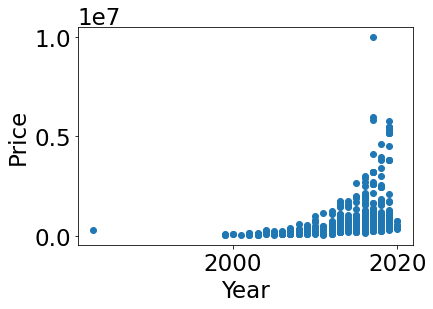

In [497]:
fig, ax = plt.subplots()
plt.xlabel("Year")
plt.ylabel("Price")
ax.scatter(df["year"][:1000], df["price"][:1000])

# Clean and Transform Data

### Create a data formatting function
This function will convert any objects or strings to categorical types for the machine learning algorithm

This function will also fill null values

In [498]:
def categorize_data(df):
    # convert objects/strings to categorical data types for our ML algorithm
    for label, content in df.items():
        if pd.api.types.is_string_dtype(content):
            df[label] = content.astype("category").cat.as_ordered()
            
        # fill missing categorical values    
        if not pd.api.types.is_numeric_dtype(content):
            df[label] = pd.Categorical(content).codes + 1 # missing values are -1 so we add 1 to everything to make them 0 
   
def format_data(df):
    
    # Fill missing numeric columns with median
    # Add additional column to indicate missing data was replaced
    for label, content in df.items():
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
                # fill missing data and add a column to indicate data was missing
                df[label] = content.fillna(content.median())
                
        # drop KMPL category as it will be shown later to be unimportant
        if label == "kmpl":
            df.drop(columns="kmpl", inplace=True)

    categorize_data(df)
    return df

In [499]:
# data before formatting
df.tail()

,name,year,price,mileage,fuel,seller_type,transmission,owner,kmpl,engine,max_power,torque,seats
8122,Hyundai i20 Magna,2013,320000,110000,Petrol,Individual,Manual,First Owner,18.5 kmpl,1197 CC,82.85 bhp,113.7Nm@ 4000rpm,5.0
8123,Hyundai Verna CRDi SX,2007,135000,119000,Diesel,Individual,Manual,Fourth & Above Owner,16.8 kmpl,1493 CC,110 bhp,"24@ 1,900-2,750(kgm@ rpm)",5.0
8124,Maruti Swift Dzire ZDi,2009,382000,120000,Diesel,Individual,Manual,First Owner,19.3 kmpl,1248 CC,73.9 bhp,190Nm@ 2000rpm,5.0
8125,Tata Indigo CR4,2013,290000,25000,Diesel,Individual,Manual,First Owner,23.57 kmpl,1396 CC,70 bhp,140Nm@ 1800-3000rpm,5.0
8126,Tata Indigo CR4,2013,290000,25000,Diesel,Individual,Manual,First Owner,23.57 kmpl,1396 CC,70 bhp,140Nm@ 1800-3000rpm,5.0


First we categorize the data and graph some columns vs price

In [500]:
categorize_data(df)

kmpl shows no correlation in this bar graph, so we remove this from our dataset in the format_data function

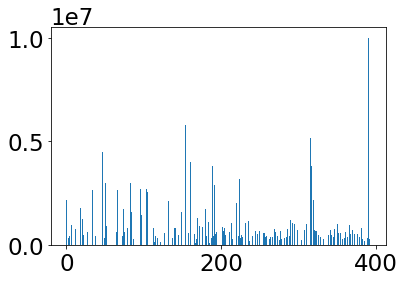

In [501]:
if "kmpl" in df:
    fig, ax = plt.subplots()
    ax.bar(df["kmpl"][:1000], df["price"][:1000])

In [502]:
# Format the DataFrame 
format_data(df)

# View the new details of the dataframe and make sure the formatting was successful
df.tail()

,name,year,price,mileage,fuel,seller_type,transmission,owner,engine,max_power,torque,seats
8122,772,2013,320000,110000,4,2,2,1,11,268,38,5.0
8123,657,2007,135000,119000,2,2,2,2,33,31,251,5.0
8124,1320,2009,382000,120000,2,2,2,1,14,242,179,5.0
8125,1700,2013,290000,25000,2,2,2,1,25,233,107,5.0
8126,1700,2013,290000,25000,2,2,2,1,25,233,107,5.0


We can see below, "torque" and "engine" may have a weak correlation with price

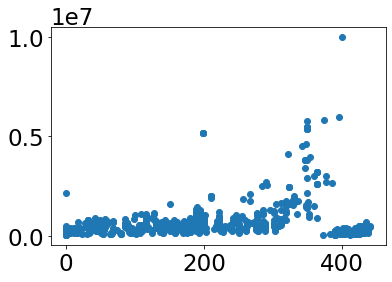

In [507]:
fig, ax = plt.subplots()
ax.scatter(df["torque"][:1000], df["price"][:1000])

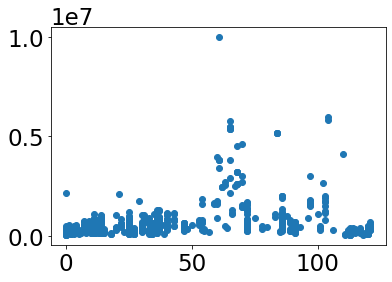

In [508]:
fig, ax = plt.subplots()
ax.scatter(df["engine"][:1000], df["price"][:1000])

# Split the Data

Split the data into training, test, and validation sets for the ML algorithm

In [509]:
dftest = df[df.index >= 7900]
dfval = df[np.logical_and(df.index >= 7600, df.index < 7900)]
dftrain = df[df.index < 7600]

### Verify that the sets were split appropriately

As we can see, the sets were split from the original with 8127 entries into 3 separate sets

In [510]:
len(dfval), len(dftrain), len(dftest)

(300, 7600, 227)

# Evaluate the Machine Learning model

### Create a function to evaluate the accuracy of the machine learning model and display results

In [511]:
# We will use the MSLE, MAPE, and R^2 score for evaluation metrics
from sklearn.metrics import mean_squared_log_error, mean_absolute_percentage_error, r2_score

# function to find RMSLE since it is not available in sklearn
def rmsle(y_actual, y_pred):
    return np.sqrt(mean_squared_log_error(y_actual, y_pred))

# make a function that evaluates the model with different criteria
def score_model(model):
    train_pred = model.predict(xtrain) # see how model performs on training set
    val_pred = model.predict(xvalid) # see how model performs on validation set
    
    # scores will return a dictionary with the results
    scores = {"Training MAPE": mean_absolute_percentage_error(ytrain, train_pred),
              "Validation MAPE": mean_absolute_percentage_error(yvalid, val_pred),
              "Training RMSLE": rmsle(ytrain, train_pred),
              "validation RMSLE": rmsle(yvalid, val_pred),
              "Training R^2": r2_score(ytrain, train_pred),
              "Validation R^2": r2_score(yvalid, val_pred)}
    return scores

# Build the Machine Learning Model

### Create the training and validation sets

Here we will separate the "price" column from the training and validation sets in order to train and evaluate the model

In [512]:
# xtrain is the training data without the price column and ytrain is the associated price column (similar for xvalid/yvalid)
xtrain, ytrain = dftrain.drop("price", axis=1), dftrain.price
xvalid, yvalid = dfval.drop("price", axis=1), dfval.price

Next, we will verify the data by printing the number of rows and columns

In [513]:
xtrain.shape, ytrain.shape, xvalid.shape, yvalid.shape

((7600, 11), (7600,), (300, 11), (300,))

### Instantiate and fit the model

In [514]:
%%time

from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_jobs=-1, random_state=42)

#fit model with training set
model.fit(xtrain, ytrain)

Wall time: 774 ms


RandomForestRegressor(n_jobs=-1, random_state=42)

## Score the model

MAPE: A lower is better, less than .3 or 30% is required

RMSLE: A lower number is better .25 is considered a good value

R^2: A number close to 1 is best, greater than .8 or 80% is required

In [515]:
score_model(model)

{'Training MAPE': 0.05870086946329486,
 'Validation MAPE': 0.14477732670510787,
 'Training RMSLE': 0.09388354531633597,
 'validation RMSLE': 0.2037596336452911,
 'Training R^2': 0.9936222841674497,
 'Validation R^2': 0.9831016476892291}

## Improve the model

Try to improve the model by finding the best hyperparameters for the model using RandomizedSearchCV

In [516]:
%%time
# takes model and searches for the best hyperparameters

from sklearn.model_selection import RandomizedSearchCV

rf = {"n_estimators": np.arange(10, 100, 10),
      "max_depth": [None, 3, 5, 10],
      "min_samples_split": np.arange(2, 20, 2),
      "min_samples_leaf": np.arange(1, 20, 2),
      "max_features": [0.5, 1, "sqrt", "auto"],
      "max_samples": [6080]}

rsModel = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1, random_state = 42), param_distributions=rf,
                                                    n_iter=1, cv=5, verbose=True)
    
rsModel.fit(xtrain, ytrain)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Wall time: 2.37 s


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=1,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1, 'sqrt',
                                                         'auto'],
                                        'max_samples': [6080],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

### Fit model with better hyperparameters

In [517]:
# Find the optimal paramaters given by RandomizedSearchCV
rsModel.best_params_

{'n_estimators': 70,
 'min_samples_split': 10,
 'min_samples_leaf': 15,
 'max_samples': 6080,
 'max_features': 'sqrt',
 'max_depth': None}

In [518]:
# after 100 iterations, we will try the parameters from RandomizedSearchCV

updated_model = RandomForestRegressor(n_estimators=40, min_samples_split=4, min_samples_leaf=1,
                                  max_samples=6080, max_features=0.5, max_depth=None, random_state=42)
updated_model.fit(xtrain, ytrain)

RandomForestRegressor(max_features=0.5, max_samples=6080, min_samples_split=4,
                      n_estimators=40, random_state=42)

As we can see below, the updated model scored a better R Squared value but was around the same or slightly worse in the other categories

In [519]:
# Show the updated model's scores
score_model(updated_model)

{'Training MAPE': 0.08916240719662542,
 'Validation MAPE': 0.14570047359817437,
 'Training RMSLE': 0.13206007500669398,
 'validation RMSLE': 0.2041086710831331,
 'Training R^2': 0.9904186244106756,
 'Validation R^2': 0.9856074076262774}

## Format test set

In [520]:
# copy the test set into a new dataframe and drop the price column

pd.options.mode.chained_assignment = None  # default='warn' -- suppress warning for modifying a DF copy
dftest1 = dftest.copy()
dftest1.drop(["price"], axis=1, inplace=True)
dftest1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 227 entries, 7900 to 8126
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   name          227 non-null    int16  
 1   year          227 non-null    int64  
 2   mileage       227 non-null    int64  
 3   fuel          227 non-null    int8   
 4   seller_type   227 non-null    int8   
 5   transmission  227 non-null    int8   
 6   owner         227 non-null    int8   
 7   engine        227 non-null    int8   
 8   max_power     227 non-null    int16  
 9   torque        227 non-null    int16  
 10  seats         227 non-null    float64
dtypes: float64(1), int16(3), int64(2), int8(5)
memory usage: 9.5 KB


## Now we can make predictions on test data

In [521]:
# predict data from test set using the model
test_pred = updated_model.predict(dftest1)

# create a dataframe with the predicted prices and actual prices to graph the results
resultdf = pd.DataFrame()
resultdf["actualPrice"] = dftest["price"]
resultdf["predictedPrice"] = test_pred
# resultdf

### Display the results and compare the predictions with actual prices

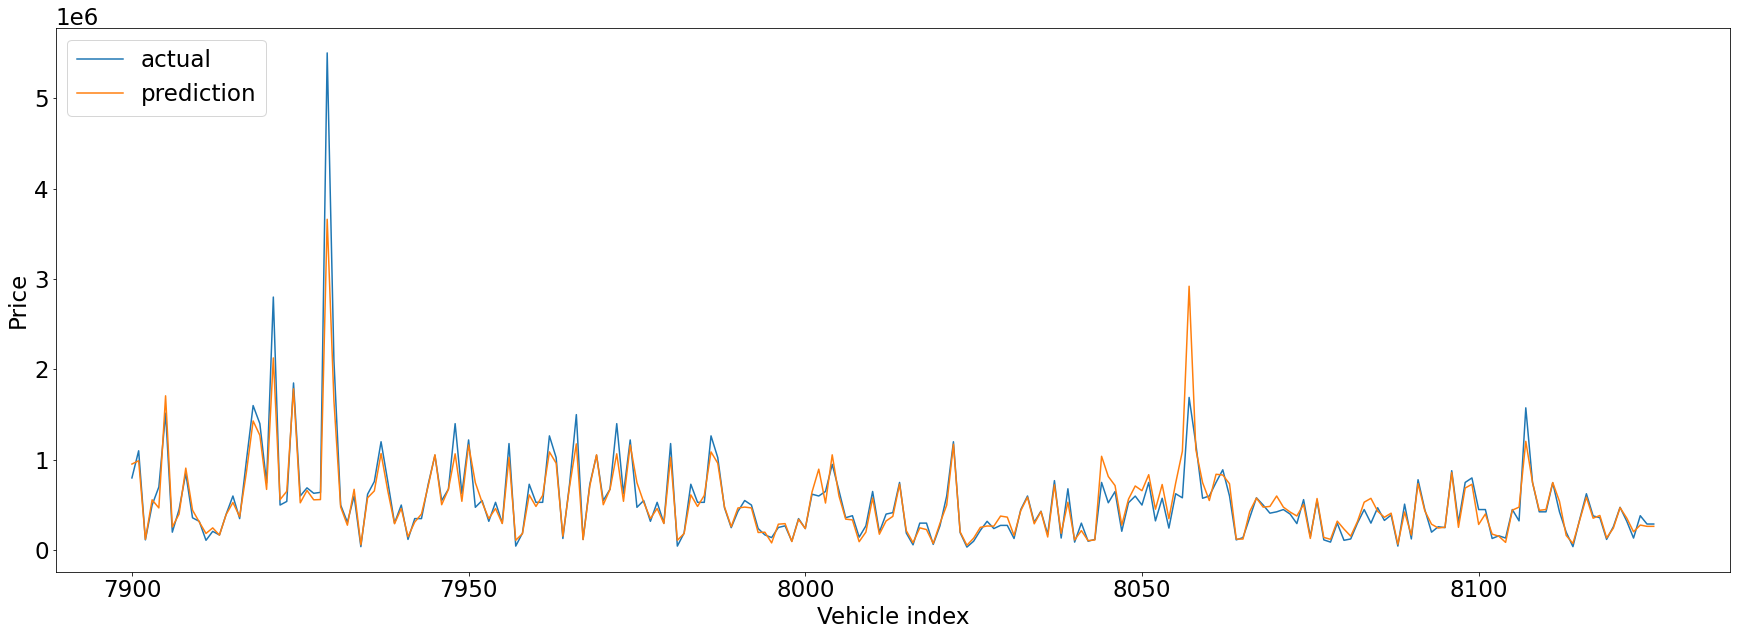

In [522]:
# Graph the actual and predicted prices to compare (x=index, y=price)
from matplotlib.pyplot import figure

plt.figure(figsize=(30,10))
plt.plot(resultdf.index, resultdf["actualPrice"], label="actual") # blue
plt.plot(resultdf.index, resultdf["predictedPrice"], label="prediction") # orange

plt.legend()
plt.legend(loc=2, prop={'size': 23})
plt.xlabel("Vehicle index")
plt.ylabel("Price")


plt.rcParams.update({'font.size': 23})

The graph above demonstrates the accuracy of the model for predicting prices

The results below also demonstrate that the model has achieved the objective accuracy targets (greater than 80% R^2 and less than 30% MAPE)

In [523]:
print("Test R^2", r2_score(dftest["price"], test_pred))
print("Test RMSLE", rmsle(dftest["price"], test_pred))
print("Test MAPE", mean_absolute_percentage_error(dftest["price"], test_pred))

Test R^2 0.8695514014857297
Test RMSLE 0.22501842888227944
Test MAPE 0.17946018819606632


# Enter User Data

## Start Here

run the section below, enter user data, then click the submit button

In [524]:
# list all values in dataset for user choices
full_df = pd.read_csv("car-data.csv")
name_list = full_df["name"].sort_values().drop_duplicates()
year_list = full_df["year"].sort_values().drop_duplicates()
fuel_list = full_df["fuel"].sort_values().drop_duplicates()
seller_list = full_df["seller_type"].sort_values().drop_duplicates()
tran_list = full_df["transmission"].sort_values().drop_duplicates()
owner_list = full_df["owner"].sort_values().drop_duplicates()
engine_list = full_df["engine"].sort_values().drop_duplicates()
power_list = full_df["max_power"].sort_values().drop_duplicates()
torque_list = full_df["torque"].sort_values().drop_duplicates()
seat_list = full_df["seats"].sort_values().drop_duplicates()

# Create a list with default values
user_list = ['Tata Indigo CR4', 2013, 25000, 'Diesel', 'Individual', 'Manual', 'First Owner', '1396 CC', '70 bhp', '140Nm@ 1800-3000rpm', 5.0]

# HTML headings
main_heading = widgets.HTML(value="<h1>Used Car Price Prediction System</h1>")
name_paragraph = widgets.HTML(value="<p>Please choose a vehicle</p>")


# Create dropdown widget
selected_name = widgets.Dropdown(layout={'width': '500px'}, options=name_list, value="Tata Indigo CR4", description='Select car')
selected_year = widgets.Dropdown(layout={'width': '500px'}, options=year_list, value=2013, description='Select year')
selected_fuel = widgets.Dropdown(layout={'width': '500px'}, options=fuel_list, value="Diesel", description='Select fuel')
selected_seller = widgets.Dropdown(layout={'width': '500px'}, options=seller_list, value="Individual", description='Select seller')
selected_tran = widgets.Dropdown(layout={'width': '500px'}, options=tran_list, value="Manual", description='Select transmission')
selected_owner = widgets.Dropdown(layout={'width': '500px'}, options=owner_list, value="First Owner", description='Select owner')
selected_engine = widgets.Dropdown(layout={'width': '500px'}, options=engine_list, value="1396 CC", description='Select engine')
selected_power = widgets.Dropdown(layout={'width': '500px'}, options=power_list, value="70 bhp", description='Select power')
selected_torque = widgets.Dropdown(layout={'width': '500px'}, options=torque_list, value="140Nm@ 1800-3000rpm", description='Select torque')
selected_seats = widgets.Dropdown(layout={'width': '500px'}, options=seat_list, value=5.0, description='Select seats')
selected_mileage = widgets.IntSlider(value=25000,min=0, max=500000, step=100, description='Mileage:', disabled=False,  continuous_update=False, orientation='horizontal',readout=True,readout_format='d')
button = widgets.Button(description='Submit',disabled=False,button_style='')

# Display HTML headings
display(main_heading)
display(name_paragraph)

# Display widget and its output
display(selected_name)
display(selected_year)
display(selected_fuel)
display(selected_seller)
display(selected_tran)
display(selected_owner)
display(selected_engine)
display(selected_power)
display(selected_torque)
display(selected_seats)
display(selected_mileage)
display(button)

output = widgets.Output()
display(output)
        
        
# selected_name widget event listener
def select(value):
    user_list.append(value)
    
def foo(b):
    user_list.clear()
    select(selected_name.value)
    select(selected_year.value)
    select(selected_mileage.value)
    select(selected_fuel.value)
    select(selected_seller.value)
    select(selected_tran.value)
    select(selected_owner.value)
    select(selected_engine.value)
    select(selected_power.value)
    select(selected_torque.value)
    select(selected_seats.value)
button.on_click(foo)

HTML(value='<h1>Used Car Price Prediction System</h1>')

HTML(value='<p>Please choose a vehicle</p>')

Dropdown(description='Select car', index=1699, layout=Layout(width='500px'), options=('Ambassador CLASSIC 1500…

Dropdown(description='Select year', index=21, layout=Layout(width='500px'), options=(1983, 1991, 1994, 1995, 1…

Dropdown(description='Select fuel', index=1, layout=Layout(width='500px'), options=('CNG', 'Diesel', 'LPG', 'P…

Dropdown(description='Select seller', index=1, layout=Layout(width='500px'), options=('Dealer', 'Individual', …

Dropdown(description='Select transmission', index=1, layout=Layout(width='500px'), options=('Automatic', 'Manu…

Dropdown(description='Select owner', layout=Layout(width='500px'), options=('First Owner', 'Fourth & Above Own…

Dropdown(description='Select engine', index=24, layout=Layout(width='500px'), options=('1047 CC', '1061 CC', '…

Dropdown(description='Select power', index=232, layout=Layout(width='500px'), options=(' bhp', '0', '100 bhp',…

Dropdown(description='Select torque', index=106, layout=Layout(width='500px'), options=('10.2@ 2,600(kgm@ rpm)…

Dropdown(description='Select seats', index=2, layout=Layout(width='500px'), options=(2.0, 4.0, 5.0, 6.0, 7.0, …

IntSlider(value=25000, continuous_update=False, description='Mileage:', max=500000, step=100)

Button(description='Submit', style=ButtonStyle())

Output()

## Format data and apply prediction using the ML model

Run the code below and it will print the prediction results 

In [525]:
# initialize df_empty
if len(full_df.columns) == 12:
    full_df = pd.read_csv("car-data.csv")
df_empty = full_df[0:0]
df_empty.drop(columns="price", inplace=True)

# add user generated data onto df_empty
df_empty = df_empty.append(pd.DataFrame([[user_list[0],user_list[1], user_list[2], user_list[3],user_list[4],
                              user_list[5], user_list[6], "23.57 kmpl", user_list[7],user_list[8], user_list[9], user_list[10]]],
                            columns=df_empty.columns))

# append df_empty onto full_df
full_df = full_df.append(df_empty)
# format full_df with new row and clear df_empty
format_data(full_df)
df_empty = full_df[0:0]
# add formated data back to df_empty
df_empty = df_empty.append(full_df.tail(1))

if "price" in df_empty:
    df_empty.drop(["price"], axis=1, inplace=True)
price = math.floor(model.predict(df_empty)[0])
print("price in rupees: ", price, "  USD: ", math.ceil(0.013*price))

price in rupees:  282539   USD:  3674
